# Introduction
Knowing all about the software system we are developing is a valuable, but too often a rare situation we are facing today. In times of software development experts shortages and stressful software projects, high turnover in teams lead quickly to lost knowledge about the source code (&lt;scrumcasm&gt;And who needs to document? We do Scrum!&lt;/scrumcasm&gt;).

I already did some calculations of the [knowledge distribution](https://www.feststelltaste.de/knowledge-islands/) of software systems based on Adam Tornhill marvelous ideas in "Your Code as a Crime Scene" ([publisher's site](https://pragprog.com/book/atcrime/your-code-as-a-crime-scene), but my recommendation is to get the [newer book](https://pragprog.com/book/atevol/software-design-x-rays)). It really did it's job. But after my experiences from a Subversion to Git migration (where I, who guessed, ensured the quality of the migrated data :-) ), I've found another neat idea for another model to find lost knowledge.

# The Idea

First: How do you define knowledge about your code? We could get into a deep philosophical discussion about what knowledge is and if there is such a thing like knowledge (invite to a beer if you want to start this discourse ;-)). But let's look at it from a developer's point of view: E. g. in my case, every time I want to know who could possible know something about a code line written, for example, for this piece of code (the meaning of the source code is irrelevant here),

![](resources/blame_game_source.png)

I'm catching myself in using the <strike>blame</strike> appraisal features of version control systems heavily. This feature calculates the latest change for each lines. The resulting view gives me very helpful hints about what changes in a source code line happened recently

![](resources/blame_game_annotate1.png)

with plenty of information about who and when this change occurred for each source code line.

![](resources/blame_game_annotate2.png)

With these results, I can take a look at the author of the code and the time stamp of the code change. This gives me enough hints about the circumstances in which the code change happened as well as the answer to the question if the original author could still possibly know anything about the source code line. For the latter, the answer is highly dependent on the recency of a code change. Here, I'm using Eagleson's law as heuristic:

<blockquote class="twitter-tweet" data-lang="de"><p lang="en" dir="ltr">Eagleson&#39;s Law: Any code of your own that you haven&#39;t looked at for six or more months might as well have been written by someone else.</p>&mdash; Programming Wisdom (@CodeWisdom) <a href="https://twitter.com/CodeWisdom/status/940007477642432514?ref_src=twsrc%5Etfw">10. Dezember 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

If the code change is older than six months, it's very likely that the knowledge about the source code line is lost completely.

So there we have it: A reasonable model of code knowledge! If we would have this information for all source code files of our software project, we would be able to identify the areas in our software system with lost knowledge (and find out, if we are <strike>screwed</strike> in a challenging situation!).

So, let's get the data we need for this analysis!

# Number Crunching

Getting the data is straightforward: We just need a software system that used a version control system like Git for managing the code changes. I choose the Git repository of Linux for this demonstration. The reason? It's big! In this repo, we have a snapshot of the last 13 years of Linux kernel development at our hand with over 750000 commits and some millions lines of source code.

We can get our hands on the necessary data with the `git blame` command that we execute for each source code file in the repository. There is a nice little bash command that makes this happen for us:

```
find . -type d -name ".git" -prune -o -type f \( -iname "*.c" -o -iname "*.h" \) | xargs -n1 git blame -w -f
```

It first finds all C programming language source code files (`.h` header files as well as th`.c` program files) and retrieves the `git blame` information for each source code line in each file. This information includes
* the sha id of the commit
* the relative path of the file
* the name of the author
* the commit time stamp
* the source line number
* the source code line itself

At this point you might ask: "OK, wait a minute: 13 years of development efforts, with around 750000 commits and (spoiler alert!) 10235 source code files that sum up to 5.6 millions lines of code. Are you insane?"

Well, kind of. I hadn't thought that retrieving the data set would take so long. But in the end, I didn't care because I did the calculation on a Google Cloud Compute Engine, which was pretty busy for 11 hours on a n1-standard-1 CPU (which cost me 30 cents, donations welcome :-D):

![](resources/blame_game_gcp.png)

The result was a 3 GB big log file that I've packed and downloaded to my computer. And this is where we start the first part our analysis with Python and Pandas!

## Wrangling the raw data
First, I want to create a nice little comma separated file with only the data we need for later analysis. This is why we first take the raw data and transform it to something we can call a decent data set.

I have my experiences with old and big repositories, so I know that it's not going to be easy to read in such a long runner. The nice and bad thing at the same time is, that the Linux kernel was developed internationally. This means: Fun with file encodings! It seems that every nation has it's own way of encoding their special character sets. Especially when working with author data, it's really a PITA. You simply cannot read in the data set with standard means. The universal weapon for this is to import data into a Pandas DataFrame with the encoding `latin-1` which seems to don't care if there are some weired characters in the data.

Additionally, there is no good format for outputting the Git blame log in a way, that it's easy to process. There are some flags for machine-friendly output, but these are multi-line formats (which are...not very nice to work with in Pandas). So in these cases, I like to <strike>eat</strike> get my data in a very raw format. There is this other trick to use a non-used separator (I prefer `\u0012`) that makes Pandas reading in a text file in one single columns.

So let's do this!

In [1]:
import pandas as pd

PATH = r"C:\Users\Markus\Downloads\linux_blame_temp.tar.gz"
blame_raw = pd.read_csv(PATH, encoding="latin-1", sep="\u0012", names=["raw"])
blame_raw.head()

,raw
0,linux_blame_temp.log
1,NaN
2,889d0d42667c9 drivers/scsi/bfa/bfad_drv.h (Ani...
3,889d0d42667c9 drivers/scsi/bfa/bfad_drv.h (Ani...
4,7725ccfda5971 drivers/scsi/bfa/bfad_drv.h (Jin...


After around 30 seconds, we read in our 3 GB Git blame log (I think it's kind of okayish). Maybe you're wondering why this takes so long. Well let's see how many entries our dataset.

In [2]:
len(blame_raw)

5665949

There are 5.6 million entries (= source code lines) that needed to be read in.

In the next code cell, we extract all the data from the `raw` column into a new DataFrame calles `blame`. We just need to figure out the right regular expression for this and we are fine. In this step, we also exclude the source code of the blame log because we actually don't need this information for our knowledge loss calculation.

As always when working with string data, this needs time.

In [3]:
blame = \
  blame_raw.raw.str.extract(
      "(?P<sha>.*?) (?P<path>.*?) \((?P<author>.* ?) (?P<timestamp>[0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} .[0-9]{4}) *(?P<line>[0-9]*)\) .*",
      expand=True)
blame.head()

,sha,path,author,timestamp,line
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,2
3,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,3
4,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-23 17:46:15 -0700,4


But after a minute we have the data in a nice DataFrame `blame`, too.

## Fixing wrong entries
In the next step, we have to face some missing data. I think I did a mistake by executing the bash command in the wrong directory. This could explain why there are some missing values. We simply drop the missing data but log the number of the missed entries to make sure we are working reproducible.

In [4]:
has_null_value = blame.isnull().any(axis=1)
dropped_entries = blame[has_null_value]
blame = blame[~has_null_value]
dropped_entries

,sha,path,author,timestamp,line
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
5665948,NaN,NaN,NaN,NaN,NaN


So we lost the first non-sense line (because of my mistake), thus the second entry for the first Git blame result as well as the last line (which is negligible in our case). For completeness reasons, let's add the first line manually (because I want to share a clean data set with you as well!).

In [5]:
blame.head()

,sha,path,author,timestamp,line
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,2
3,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,3
4,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-23 17:46:15 -0700,4
5,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,5
6,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-23 17:46:15 -0700,6


We take the second line and alter the data so that we have the first line again (as long as we have good and comprehensibly reasons for this, I find this approach OK here).

In [8]:
first_line = blame.loc[2].copy()
first_line.line = 1
first_line

sha                        889d0d42667c9
path         drivers/scsi/bfa/bfad_drv.h
author                Anil Gurumurthy   
timestamp      2015-11-26 03:54:45 -0500
line                                   1
Name: 2, dtype: object

We transform our single entry back into a DataFrame, transpose the data and concatenate our `blame` DataFrame to it.

In [9]:
blame = pd.concat([pd.DataFrame(first_line).T, blame])
blame.head()

,sha,path,author,timestamp,line
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,1
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,2
3,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,3
4,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-23 17:46:15 -0700,4
5,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 03:54:45 -0500,5


After this, we do some housekeeping of the data:
* We fix the comma-separated values in the author's column because we want to use the comma as separator for our comma-separated values (CSV) file
* We also change the data type of the time stamp from a string to a `TimeStamp` to check it's data quality

To improve performance (heavily!), we first convert both columns into `Categorical` data to enable working with references instead of manipulating the values for all entries. It the end, this means that the same values need to be changed and converted only once.

In [10]:
blame.author = pd.Categorical(blame.author)
blame.author = blame.author.str.strip()
blame.author.str.split(",")[::-1].str.join(" ")

blame.timestamp = pd.Categorical(blame.timestamp)
blame.timestamp = pd.to_datetime(blame.timestamp)
blame.head()

,sha,path,author,timestamp,line
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2
3,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3
4,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4
5,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5


This operation still takes around 10 seconds (instead of minutes!), but we have now a decent data set that we can use further on.

Next, we take a look at another possible area of errors: The `TimeStamp` column.

In [11]:
blame.timestamp.describe()

count                 5665947
unique                  92466
top       2005-04-16 22:20:36
freq                   836898
first     2002-04-09 19:14:34
last      2018-04-11 17:26:09
Name: timestamp, dtype: object

Apparently, the Linux Git repository has also some issues with timestamps. The (still) top occurring time stamp is the initial commit of Lunux Torvalds in April 2005. There is nothing we can do about that than mention that here. But there are also changes that are older than that. This is an error caused by wrong clock configurations from a few developers. This leaves us with no other choice with either deleting the entries with that data or assigning them to the initial commits.

Because in our case, we want to have a complete data set, we choose the second option. Not quite clean, but the best decision we can make in our situation. And always remember:

<blockquote><p lang="en" dir="ltr">All models are wrong but some are useful</p>&mdash; George Box</blockquote>

Let's find the initial commit of Linux Torvalds.

In [12]:
initial_commit = blame[blame.author == "Linus Torvalds"].timestamp.min()
initial_commit

Timestamp('2005-04-16 22:20:36')

We keep track of all wrong timestamps and set those to the initial commit time stamp.

In [13]:
is_wrong_timestamp = blame.timestamp < initial_commit
wrong_timestamps = blame[is_wrong_timestamp]
blame.timestamp = blame.timestamp.clip(initial_commit)
len(wrong_timestamps)

4955

Further, we convert the `TimeStamp` column to an integer to save some storage and to enable efficient time stamp transformation when reading the data in later on


In [14]:
blame.timestamp = blame.timestamp.astype('int64')
blame.head()

,sha,path,author,timestamp,line
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,1
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,2
3,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,3
4,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,1253753175000000000,4
5,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,5


Last, we store the result in a gzipped CSV file as immediate result.

In [15]:
blame.to_csv("C:/Temp/linux_blame.gz", encoding='utf-8', compression='gzip', index=None)

All right, the ugly work finished! Let's get some insights!

# Analyzing the knowledge about Linux

## Importing the data set
First, we reimport our newly created data set to check if it's as expected.

In [16]:
git_blame = pd.read_csv("C:/Temp/linux_blame.gz")
git_blame.head()

,sha,path,author,timestamp,line
0,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,1
1,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,2
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,3
3,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,1253753175000000000,4
4,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,5


Let's first have a look at what we've got here now.

In [17]:
git_blame.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 5 columns):
sha          object
path         object
author       object
timestamp    int64
line         int64
dtypes: int64(2), object(3)
memory usage: 1.3 GB


We have our 5.6 million Git blame log entries that are stored in memory with 1.3 GB. We need (as always) do some data wrangling by apply some data conversions. In this case, we convert the `sha`, `path`, and `author` columns to `Categorical` data (as mentioned, because of performance reasons).

In [18]:
git_blame.sha = pd.Categorical(git_blame.sha)
git_blame.path = pd.Categorical(git_blame.path)
git_blame.author = pd.Categorical(git_blame.author)
git_blame.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 5 columns):
sha          category
path         category
author       category
timestamp    int64
line         int64
dtypes: category(3), int64(2)
memory usage: 140.3 MB


This bring down the data in memory down to 140 MB. Next, we convert the time stamp from nanoseconds to real `TimeStamp` data.

In [19]:
git_blame.timestamp = pd.to_datetime(git_blame.timestamp)
git_blame.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 5 columns):
sha          category
path         category
author       category
timestamp    datetime64[ns]
line         int64
dtypes: category(3), datetime64[ns](1), int64(1)
memory usage: 140.3 MB


This didn't improve the memory usage further, but we now have a nice `TimeStamp` data type in the `timestamp` column that makes working with date based data easy as pie.

## Key data
Alright, time to get some overview over our data set.

Let's first look about many files we are talking about here.

In [20]:
git_blame.path.nunique()

10235

What is the biggest file?

In [21]:
git_blame[git_blame.line == git_blame.line.max()]

,sha,path,author,timestamp,line
4401067,8dbb0dc2cb160,drivers/net/ethernet/broadcom/tg3.c,Peter HÃ¼we,2013-05-21 12:58:06,18336


For which source file do we have to asked most of the authors?

In [22]:
authors_per_file = git_blame.groupby(['path']).author.nunique()
authors_per_file[authors_per_file == authors_per_file.max()]

path
drivers/pci/quirks.c    145
Name: author, dtype: int64

And for how many source files is only one author coding?

In [23]:
authors_per_file[authors_per_file == 1].count()

1903

Let's do some analysis regarding knowledge.

## Active knowledge carrier
Let's see (after Eagleson's law) which developers changes most of the source code files in the last six months.

We first create the timestamp six month ago

In [24]:
six_months_ago = pd.Timestamp('now') - pd.DateOffset(months=6)
six_months_ago

Timestamp('2017-10-23 15:19:17.994524')

and create a new column named `knowing` to get the information for the more recent changes.

In [25]:
git_blame['knowing'] = git_blame.timestamp >= six_months_ago
git_blame.head()

,sha,path,author,timestamp,line,knowing
0,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False
1,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False
3,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False
4,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False


Let's have look at the ratio between known code and unknown code (older than six months).

0.04005473401


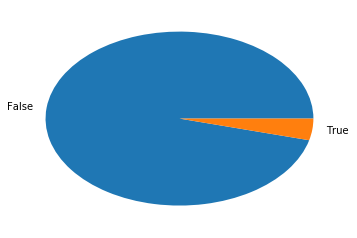

In [26]:
%matplotlib inline
git_blame['knowing'].value_counts().plot.pie(label="");
print(git_blame['knowing'].mean())

Phew...only 4% of the code changes occured in the last six months. This is what I would call "challenging".

We need to take action! So let's find out which developers did the most changes (maybe sending them some presents can help here :-)).

In [27]:
top10 = git_blame[git_blame.knowing].author.value_counts().head(10)
top10

Anirudh Venkataramanan    18790
Yasunari Takiguchi        12891
Tomer Tayar                6458
Jacopo Mondi               5260
Mauro Carvalho Chehab      4643
Edward Cree                4484
Linus Walleij              3720
Salil Mehta                3719
Jakub Kicinski             3640
Tim Harvey                 3460
Name: author, dtype: int64

## Active developed components

We can also find out in which code areas is still knowledge available and which one are the "no go areas" in our code base. For this, we aggregate our data on a higher level by looking at the source code at the component level. In the Linux kernel, we can easily create this view because mostly, the first two parts of the source code path indicates the component.

In [28]:
git_blame.path.value_counts().head()

drivers/media/dvb-frontends/drx39xyj/drxj_map.h    15055
drivers/isdn/hardware/eicon/message.c              14954
drivers/net/ethernet/sfc/mcdi_pcol.h               14534
drivers/net/ethernet/intel/i40e/i40e_main.c        14484
drivers/staging/rdma/hfi1/chip.c                   13914
Name: path, dtype: int64

We need to do some string magic to fetch only the first two parts.

In [29]:
git_blame['component'] = git_blame.path.str.split("/", n=2).str[:2].str.join(":")
git_blame.head()

,sha,path,author,timestamp,line,knowing,component
0,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False,drivers:scsi
1,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False,drivers:scsi
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False,drivers:scsi
3,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False,drivers:scsi
4,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False,drivers:scsi


After this, we can group our data by the new `component` column and calculate the ratio of known and not known code by using the `mean` method.

In [30]:
knowledge_per_component = git_blame.groupby('component').knowing.mean()
knowledge_per_component.head()

component
arch:arc     0.000000
arch:arm     0.000118
arch:i386    0.000000
arch:ia64    0.000000
arch:mips    0.000000
Name: knowing, dtype: float64

We can create a little visualization of the top 10 known parts with a bar chart.

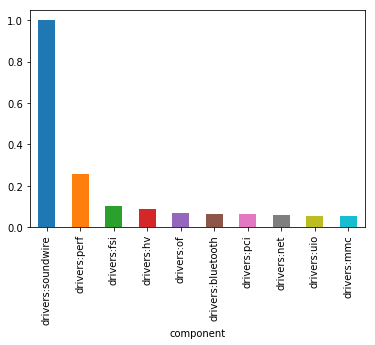

In [31]:
knowledge_per_component.sort_values(ascending=False).head(10).plot.bar();

And there might be still the chance to find some author how knows everything about the soundwire component.

## Top 10 No-Go Areas

But where are the no-go areas in the Linux kernel project? That means which are the oldest part of the system (where it is also likely that nobody knows anything all all)? For this, we create a new column named age that calculated the difference between today and the `timestamp` column.

In [32]:
git_blame['age'] = git_blame.timestamp - pd.Timestamp('now')
git_blame.head()

,sha,path,author,timestamp,line,knowing,component,age
0,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False,drivers:scsi,-880 days +17:35:17.255774
1,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False,drivers:scsi,-880 days +17:35:17.255774
2,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False,drivers:scsi,-880 days +17:35:17.255774
3,7725ccfda5971,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False,drivers:scsi,-3134 days +09:26:47.255774
4,889d0d42667c9,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False,drivers:scsi,-880 days +17:35:17.255774


In [50]:
delta = git_blame[0:100]
delta.age.mean()

Timedelta('-2817 days +19:11:23.715774')

We need a little helper method `mean` that calculated the mean time stamp delta for each component. 

In [79]:
def mean(x):
    return x.mean()

mean_age_per_component = git_blame.groupby('component').age.agg([mean, 'count'])
mean_age_per_component.head()

,mean,count
component,,
arch:arc,-1143 days +06:07:21.329728,311
arch:arm,-2875 days +10:01:03.022084,8507
arch:i386,-4638 days +12:23:37.083849,6561
arch:ia64,-4508 days +13:41:04.262485,298
arch:mips,-2804 days +16:19:19.844315,192


In [85]:
top10_no_go_areas = mean_age_per_component.sort_values('mean').head(10)
top10_no_go_areas

,mean,count
component,,
arch:sparc64,-4745 days +23:50:41.274642,530
arch:i386,-4638 days +12:23:37.083849,6561
drivers:usb,-4588 days +01:51:34.595291,9163
arch:ia64,-4508 days +13:41:04.262485,298
drivers:parisc,-4484 days +17:22:24.993651,12765
drivers:sn,-4439 days +14:23:49.617577,843
include:asm-arm,-4426 days +03:20:13.271277,129
drivers:isdn,-4325 days +13:04:03.079078,184917
arch:powerpc,-4313 days +16:24:55.770725,1973


I personally think the result isn't as bad as it looks at the first glance.

The oldest parts of the system are archaic computer architectures like Sparc64, i386 (`archaic`) 

We got also lucky with the component `drivers:isdn`, where we have around 184917 lines of rotted code. In the age of glass fiber, we surely don't need any improvements in the [ISDN](https://en.wikipedia.org/wiki/Integrated_Services_Digital_Network) features of Linux.

In [ ]:
git_blame.age.mean()

# Conclusion

One remark on the meta level:
Did I exaggarate by taking the complete Git blame log from one of the biggest open-source projects out there? Absolutely! Couldn't I just exported the really needed sub data set for the analysis? For Sure!

But beneath showing you what you can find out with the data set, I wanted to show that it's absolutely no problem when working with a 3 GB data set. You don't need any Big Data tools or set up a cluster for computations. With Pandas, r. g. I can execute these analysis on a six year old notebook.